In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import time

In [2]:
def mean_of_cluster(img, cluster_arr):
        avg = np.array([0.0, 0.0, 0.0])
        
        for num in cluster_arr:
            avg = avg + img[num]
        
        return avg / len(cluster_arr)

def distance_2(val1, val2):
    # clusters_i and cluster_j are the pixel idx    
    dist = np.sqrt(np.sum(np.power(val1 - val2, 2)))
    return dist


def init_dist_arr(img, clusters):
        n = len(clusters)
        cent_mean_arr = []
        
        for i in range(n):
            cent_mean_arr.append(mean_of_cluster(img, [i]))
    
        return cent_mean_arr


def ahc(img, clusters: dict, K: int):

    """initial cluster size = 1"""
    # init the distance matrix   
    cent_mean_arr = init_dist_arr(img, clusters)
    
    while len(clusters) > K:
        n = len(clusters)
        tmp_best_dist = float('inf')
        tmp_best_clusters = (-1, -1)
        
        # calculate two closest cluster
        distance_matrix = cdist(cent_mean_arr, cent_mean_arr, metric='euclidean')
        np.fill_diagonal(distance_matrix, np.inf)
        min_index = np.argmin(distance_matrix)
        min_row, min_col = np.unravel_index(min_index, (n, n))
        tmp_best_clusters = sorted((min_row, min_col))

        # combine 2 closest clusters
        i, j = tmp_best_clusters
        #print(i,j,"-",clusters[i], clusters[j])
        
        clusters[i].extend(clusters[j])
        del clusters[j]
        
        cent_mean_arr[i] = mean_of_cluster(img, clusters[i])
        del cent_mean_arr[j]
        
    
    for i in range(len(cent_mean_arr)):
        cent_mean_arr[i] = cent_mean_arr[i].astype(float)
        
    return cent_mean_arr
            

In [3]:
def plot_img(img: np.array, centroids: np.array):
    q_image = quantize_image(img, centroids)
    plt.imshow(q_image, cmap=None)
    plt.axis('off')
    plt.title(f'K = {len(centroids)}')
    plt.tight_layout()
    plt.savefig(f'ahc{len(centroids)}.svg', format='svg', bbox_inches='tight')


def quantize_image(img: np.array, centroids: np.array) -> np.array:
    quantized_image = img.copy()
    dim0 = img.shape[0]
    dim1 = img.shape[1]
    
    # iterates over img pixels
    for i in range(dim0):
        for j in range(dim1):
            # (i,j) current pixel position
            pixel_val = quantized_image[i][j]
            diff = pixel_val - centroids
            
            # picks the cluster that has smallest distance
            norms = np.linalg.norm(diff, axis=1)
            centroid_index = np.argmin(norms)
            quantized_image[i][j] = centroids[centroid_index]
    
    return quantized_image

In [4]:
def SSE_Loss(img: np.array, centroids: np.array):
    dim0 = img.shape[0]
    dim1 = img.shape[1]
    
    sse_loss = 0
    
    # iterates over img pixels
    for i in range(dim0):
        for j in range(dim1):
            # (i,j) current pixel position
            pixel_val = img[i][j]
            diff = pixel_val - centroids
            
            # picks the cluster that has smallest distance
            norms = np.linalg.norm(diff, axis=1)
            centroid_index = np.argmin(norms)
            corresponding_centroid = centroids[centroid_index]
            
            err = np.sum(np.power(pixel_val - corresponding_centroid, 2))
        
            sse_loss += err
     
    return sse_loss / (dim0*dim1)

def run_ahc(img: np.array):
    # img x, y
    x, y = img.shape[0], img.shape[1]

    # img channels
    c = img.shape[2]

    # log data
    k_cluster_size = list()
    k_losses = list()
    k_centroids = list()
    k_times = list()

    # initialize K number of centroids
    number_of_pixels = x * y
    img2 = img.reshape(number_of_pixels, -1)
    assert img2.shape == (number_of_pixels, 3)

    subset_indices = np.random.choice(number_of_pixels, size=3000, replace=False)
    
    for k in [2, 3, 4, 5, 6]:
        clusters = [[idx] for idx in subset_indices]
        
        start = time.perf_counter()
        
        # run ahc
        centroids = ahc(img2, clusters, k)
        
        end = time.perf_counter()
        time_elapsed = end - start
        
        # calculate the loss
        sse_loss = SSE_Loss(img, centroids)
        print(f"K {k}, SE Loss: {sse_loss}")
        
        # log the outputs
        k_cluster_size.append(k)
        k_losses.append(sse_loss)
        k_centroids.append(centroids.copy())
        k_times.append(time_elapsed)
        
        #if input("Continue?: y/n") == 'n':
         #   break
    return k_cluster_size, k_losses, k_centroids, k_times

In [5]:
img = np.array(Image.open('sample.jpg'))/255

In [6]:
k_cluster_size, k_losses, k_centroids, k_times = run_ahc(img)

K 2, SE Loss: 0.09509445501616474
K 3, SE Loss: 0.05968298435991271
K 4, SE Loss: 0.0338395253609955
K 5, SE Loss: 0.033654122839781336
K 6, SE Loss: 0.02488422073026905


In [7]:
k_losses

[0.09509445501616474,
 0.05968298435991271,
 0.0338395253609955,
 0.033654122839781336,
 0.02488422073026905]

In [8]:
k_times

[38.17029385594651,
 37.79081634595059,
 37.940711994073354,
 37.65891841100529,
 37.84312532097101]

In [10]:
img.shape

(435, 510, 3)

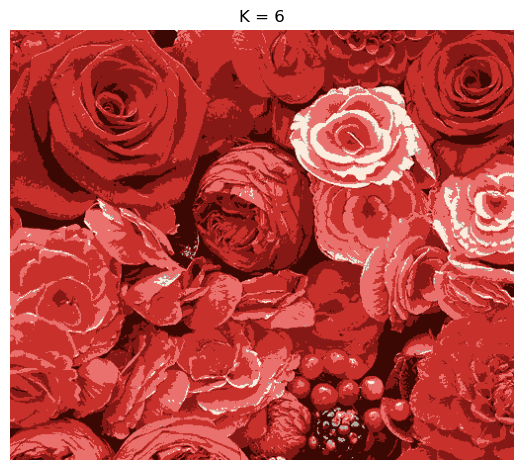

In [9]:
for centroid in k_centroids:
    plot_img(img, centroid)

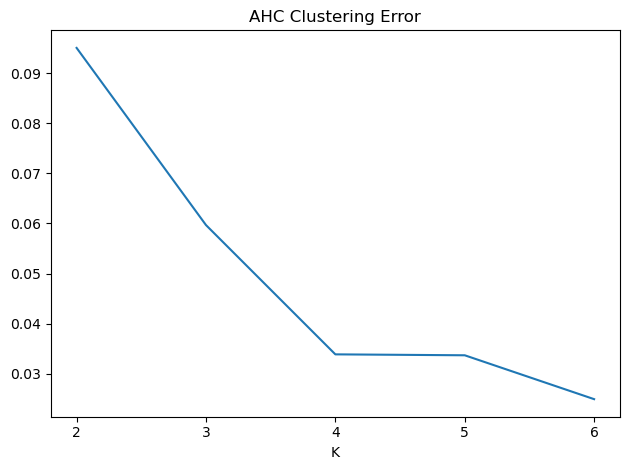

In [14]:
plt.plot([2,3,4,5,6], k_losses)
plt.xticks([2,3,4,5,6], ['2','3','4','5','6'])
plt.title("AHC Clustering Error")
plt.xlabel('K')
plt.tight_layout()
plt.savefig(f'ahc_ce.svg', format='svg', bbox_inches='tight')